# Blood cells cancer using MobileNetV2 (with transfer learning) in a Federated Learning context

## Download dataset from Kaggle

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andreiovidiumuntean","key":"589cc73e5a2e1d3c6be2ea858db432c7"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mohammadamireshraghi/blood-cell-cancer-all-4class

100% 1.68G/1.68G [00:18<00:00, 88.9MB/s]
100% 1.68G/1.68G [00:18<00:00, 97.4MB/s]


In [5]:
! unzip -q blood-cell-cancer-all-4class.zip

In [6]:
# Remove spaces from folder names
! mv "Blood cell Cancer [ALL]" dataset
! mv dataset/"[Malignant] Pre-B" dataset/pre_b
! mv dataset/"[Malignant] Pro-B" dataset/pro_b
! mv dataset/"[Malignant] early Pre-B" dataset/early_pre_b
! mv dataset/"Benign" dataset/benign

## Imports

In [7]:
from imutils import paths
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology
import time

import keras,math
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D,BatchNormalization
from keras.layers import Dense,Dropout
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics

## Preparing the dataset

In [8]:
!mkdir -p tmp/train/

!mkdir tmp/train/benign
!mkdir tmp/train/pre_b
!mkdir tmp/train/pro_b
!mkdir tmp/train/early_pre_b

!mkdir tmp/test/

!mkdir tmp/test/benign
!mkdir tmp/test/pre_b
!mkdir tmp/test/pro_b
!mkdir tmp/test/early_pre_b

In [9]:
data_dir  = 'dataset'
data_list = sorted(list(paths.list_images(data_dir)))

random.seed(88)
random.shuffle(data_list)

train_list, test_list = train_test_split(data_list, train_size=0.90, shuffle=True, random_state=88)

print('number of testing list:',len(test_list))
print('number of training list:',len(train_list))

number of testing list: 325
number of training list: 2917


In [10]:
def preprocess_data(type, paths):
  for idx, path in enumerate(paths):
    i= cv2.imread(path)
    i= cv2.resize(i,(224,224))
    label = path.split(os.path.sep)[1]
    b = f"tmp/{type}/{label}/{label}_{str(idx)}.png"
    cv2.imwrite(b, i)

In [11]:
preprocess_data("test", test_list)
preprocess_data("train", train_list)

## Create dataframe with file path and label (for test/train)

In [12]:
def load_data(directory_path):
    filenames = sorted(list(paths.list_images(directory_path)))
    random.shuffle(filenames)
    labels = [os.path.basename(os.path.dirname(filename)) for filename in filenames]
    return pd.DataFrame({'filenames': filenames, 'labels': labels})

<Axes: title={'center': 'Test Label Distribution'}>

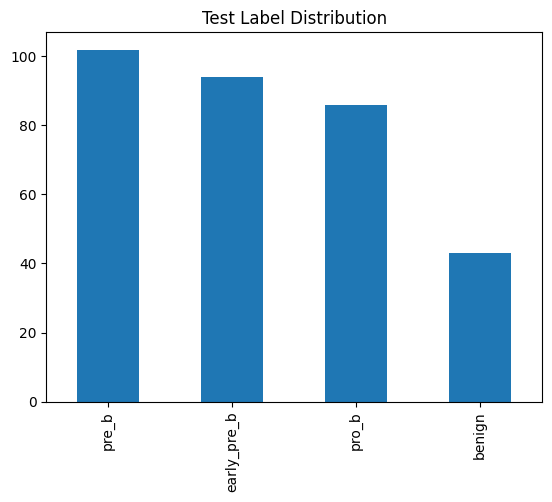

In [13]:
test_df = load_data('tmp/test/')
test_df['labels'].value_counts().plot(kind='bar', title="Test Label Distribution")

<Axes: title={'center': 'Train Label Distribution'}>

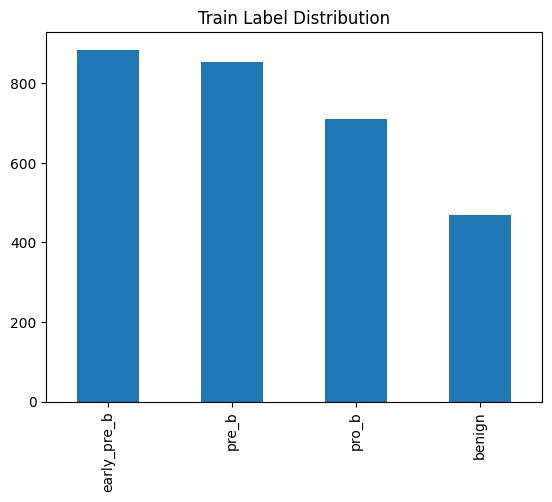

In [14]:
train_df = load_data('tmp/train/')
train_df['labels'].value_counts().plot(kind='bar', title="Train Label Distribution")

In [15]:
SPLIT= 0.90

TRAIN_DF, VALID_DF = train_test_split(train_df, train_size=SPLIT, shuffle=True, random_state=88)

print('Train samples: ', len(TRAIN_DF))
print('Valid samples: ', len(VALID_DF))
print('Test samples : ', len(test_df))

Train samples:  2625
Valid samples:  292
Test samples :  325


In [16]:
BATCH_SIZE= 32
IMG_SHAPE= (224, 224, 3)
IMG_SIZE= (224, 224)

gen = ImageDataGenerator(rescale=1./255,
                         vertical_flip=True,
                         horizontal_flip=True)
                         #rotation_range=10)

gen2 = ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(TRAIN_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)

valid_gen= gen2.flow_from_dataframe(VALID_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)
test_gen= gen2.flow_from_dataframe(test_df,
                                   x_col= 'filenames',
                                   y_col= 'labels',
                                   target_size= IMG_SIZE,
                                   class_mode= 'categorical',
                                   color_mode= 'rgb',
                                   shuffle= True,
                                   batch_size= 325,
                                   seed=88
)


STEPS= int( len(train_gen.labels)/BATCH_SIZE)
print(STEPS)

Found 2625 validated image filenames belonging to 4 classes.
Found 292 validated image filenames belonging to 4 classes.
Found 325 validated image filenames belonging to 4 classes.
82


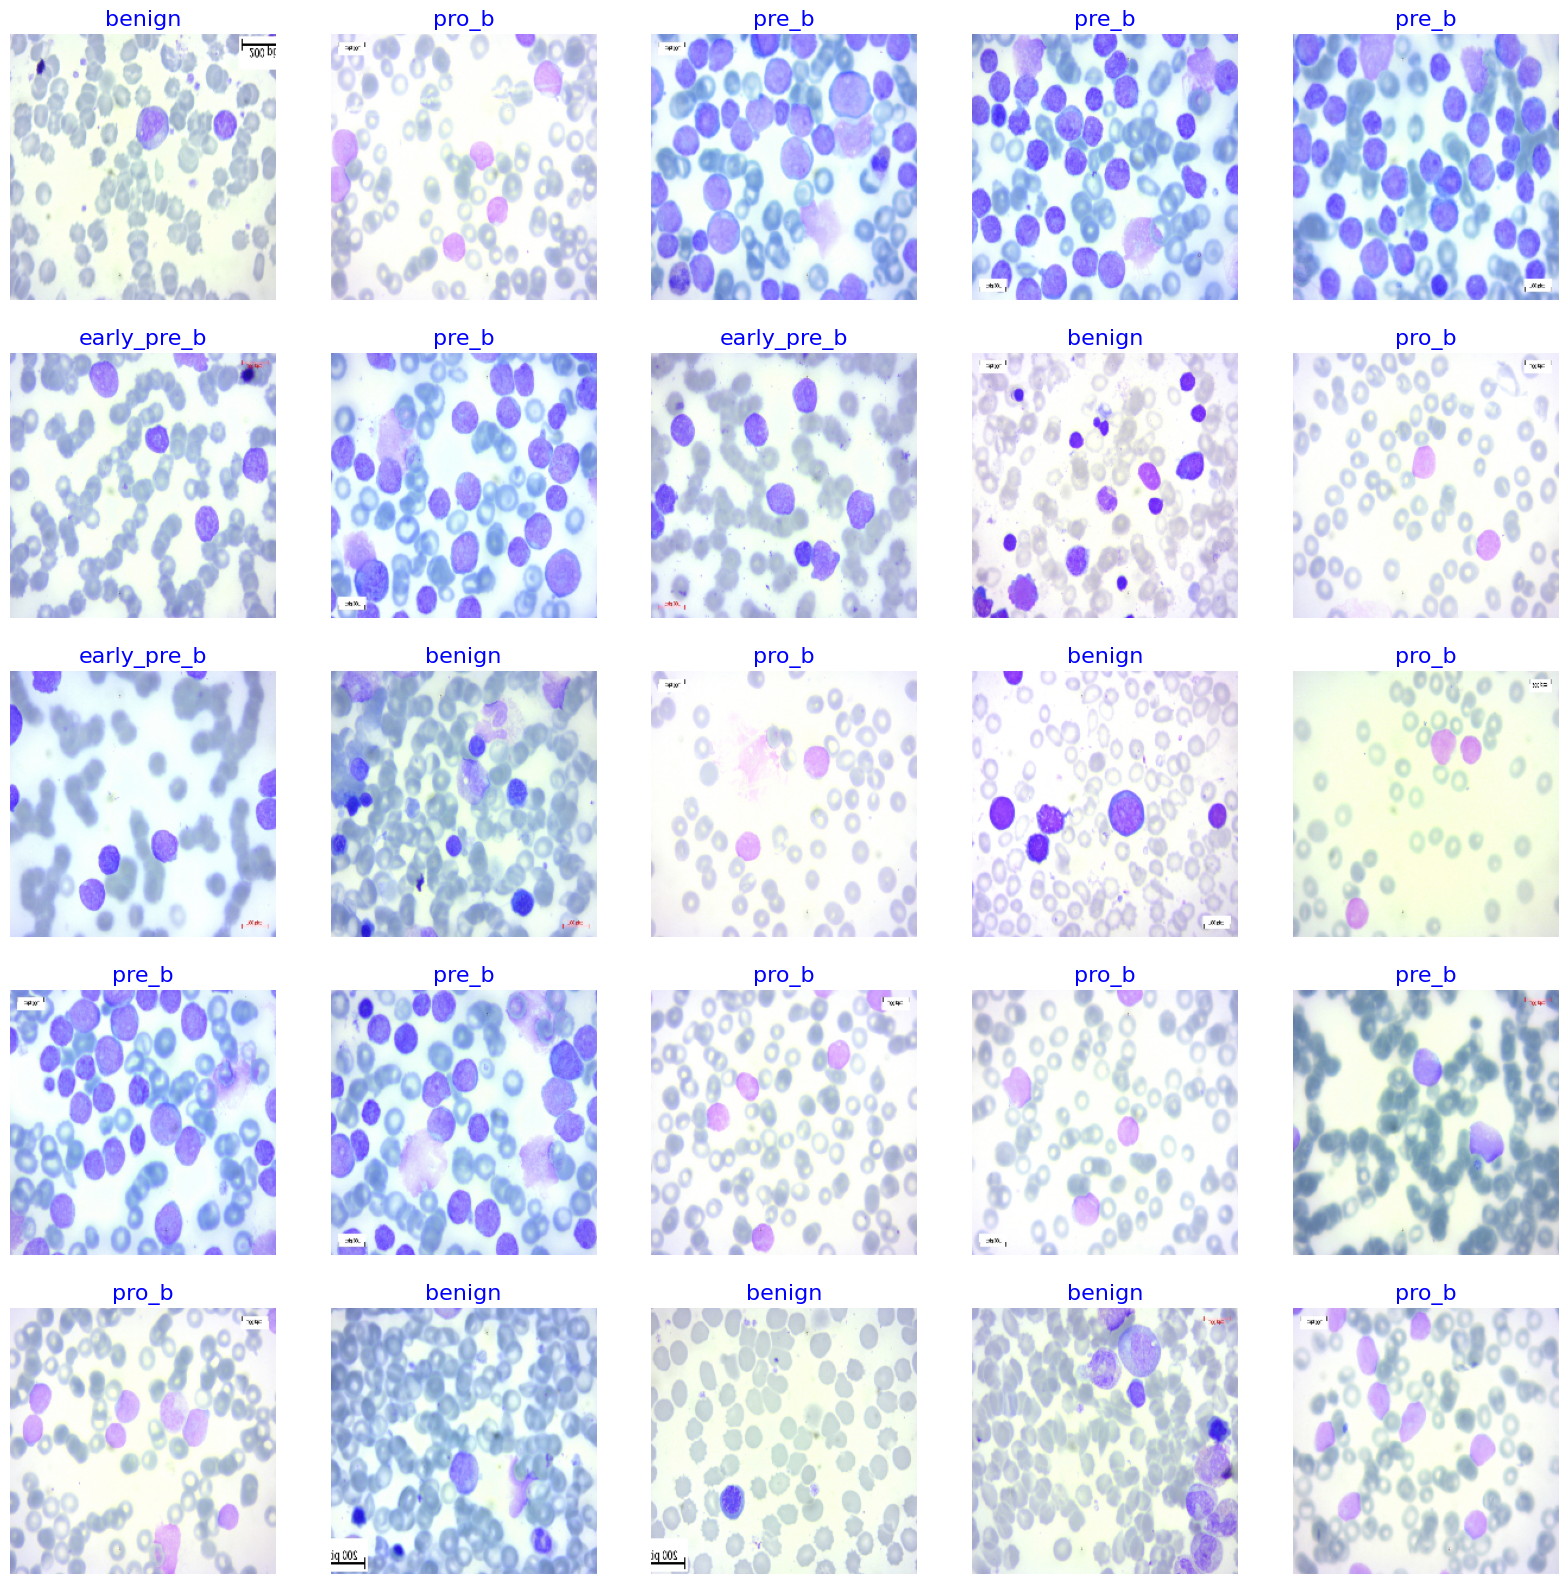

In [17]:
#---- print 25 samples of trainig dataset -----

genn=train_gen
class_dictionary= genn.class_indices
class_names = list(class_dictionary.keys())
images, labels = next(genn) #get sample batch from the generator
plt.figure(figsize=(20,20))
length = len(labels)

if length<25:
    r=length
else:
    r=25

for i in range(r):
    plt.subplot(5, 5, i+1)
    image= (images[i])
    #image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name= class_names[index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
plt.show()

In [36]:
base_model= tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,weights='imagenet',input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
#x = Dense(128, activation= 'relu',kernel_initializer='he_uniform')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
predictions = Dense(4, activation= "softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [37]:
print(base_model.input)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None,

In [28]:
print(len(model.layers))

157


In [38]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08), #optimizer=Adam(learning_rate=0.00001,decay = 10e-5),
              metrics=['accuracy'])
             # option = run_opts)

In [39]:
history =model.fit(x=train_gen,
                   epochs=15,
                   validation_data=valid_gen,
                   steps_per_epoch=None,
                   workers=2)

Epoch 1/15
83/83 [==============================] - 133s 2s/step - loss: 1.2642 - accuracy: 0.4979 - val_loss: 0.9631 - val_accuracy: 0.6644
Epoch 2/15
83/83 [==============================] - 125s 1s/step - loss: 0.7419 - accuracy: 0.7295 - val_loss: 0.6686 - val_accuracy: 0.8253
Epoch 3/15
83/83 [==============================] - 115s 1s/step - loss: 0.5093 - accuracy: 0.8248 - val_loss: 0.5020 - val_accuracy: 0.8699
Epoch 4/15
83/83 [==============================] - 125s 1s/step - loss: 0.4191 - accuracy: 0.8709 - val_loss: 0.3953 - val_accuracy: 0.9075
Epoch 5/15
83/83 [==============================] - 125s 1s/step - loss: 0.3655 - accuracy: 0.8819 - val_loss: 0.3268 - val_accuracy: 0.9212
Epoch 6/15
83/83 [==============================] - 124s 1s/step - loss: 0.3171 - accuracy: 0.9074 - val_loss: 0.2823 - val_accuracy: 0.9212
Epoch 7/15
83/83 [==============================] - 126s 1s/step - loss: 0.2918 - accuracy: 0.9162 - val_loss: 0.2551 - val_accuracy: 0.9281
Epoch 8/15
83

In [42]:
acc=model.evaluate(test_gen,batch_size=32, steps=None, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)

1/1 [==============================] - 18s 18s/step - loss: 0.2045 - accuracy: 0.9200


In [43]:
model.save('mobilenetv2_transfer_learning_model.h5')

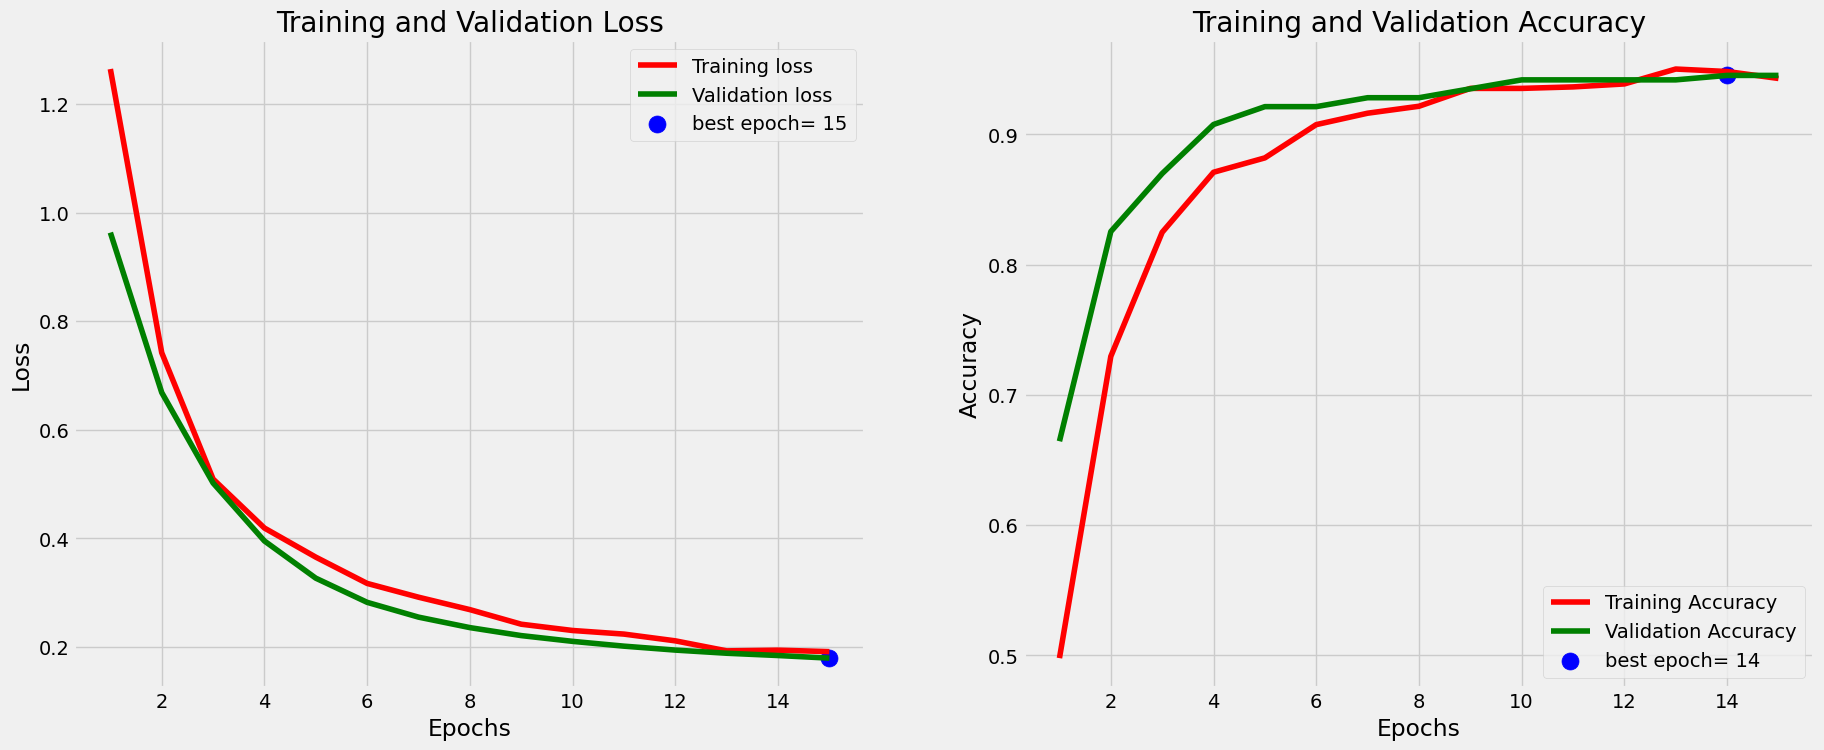

1/1 [==============================] - 18s 18s/step - loss: 0.2045 - accuracy: 0.9200
Model accuracy on test set: 92.00000166893005 (0, 255, 0) (55, 65, 80)


In [46]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


tr_plot(history, 0)
acc=model.evaluate(test_gen,batch_size=32, steps=None, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print(msg, (0,255,0), (55,65,80))